# 03. PyTorch Computer Vision

**Q**: What is Computer Vision?

**A**: Allows Computers to process visual data

**Q**: What is a Convolutional Neural Network?

**A**: Allows Computers to process visual data


In [2]:
'''
Computer Vision Libraries:
    - torchvision (PyTorch's computer vision library)
    - torchvision.datasets (Get datasets and data loading functions)
    - torchvision.transforms (functions for manipulating images)
    - torch.models (get pre-trained computer vision models)
    - torch.utils.data.DataLoader (Creates a Python iterable over a dataset)
    - torch.utils.data.Dataset (An abstract class representing a dataset)
'''

"\nComputer Vision Libraries:\n    - torchvision (PyTorch's computer vision library)\n    - torchvision.datasets (Get datasets and data loading functions)\n    - torchvision.transforms (functions for manipulating images)\n    - torch.models (get pre-trained computer vision models)\n    - torch.utils.data.DataLoader (Creates a Python iterable over a dataset)\n    - torch.utils.data.Dataset (An abstract class representing a dataset)\n"

In [3]:
# Import all the necessary libraries

import torch
from torch import nn
import torchvision
from torchvision import *
from matplotlib import pyplot as plt

#### 1. Getting a Dataset

In [ ]:
''' 
We will be using the FashionMNIST dataset for this tutorial.
    -> FashionMNIST is a dataset of Zalando's article images 
        consisting of 60,000 training examples and 10,000 test examples.
'''

# Load the FashionMNIST dataset
# Load the training set
train_data = datasets.FashionMNIST(
    root = 'data', # Location where the data will be downloaded
    train = True, # Do we want the training set?
    download = True, # Should the data be downloaded?
    transform = transforms.ToTensor(), # how do we want to transform the data?
    target_transform = None # how do we want to transform the labels/targets?
)

# Load the test set
test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transforms.ToTensor(),
    target_transform = None
)

'''
A little bit about the FashionMNIST dataset:
    - The FashionMNIST dataset consists of 60,000 training examples and 10,000 test examples.
    - Each example is a 28x28 grayscale image.
    - Each example is associated with a label from 10 classes.
    - The dataset is split into two parts: training and test.
    - The training set consists of 60,000 examples and the test set consists of 10,000 examples.
    - The labels are as follows:
        0: T-shirt/top
        1: Trouser
        2: Pullover
        3: Dress
        4: Coat
        5: Sandal
        6: Shirt
        7: Sneaker
        8: Bag
        9: Ankle boot
'''

train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

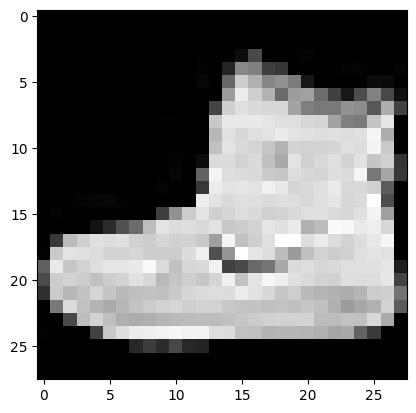

In [5]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')

#### 2. Preparing the Dataset

DataLoader turns our dataset into a Python Iterable, changes our dataset into batches

Why do we do this?
1. It is computationally efficient.
2. It gives our neural network more chances to update its gradients per epoch.

In [36]:
from torch.utils.data import DataLoader

# Setup the batch size Hyperparameter
BATCH_SIZE = 32

# Turn dataset into iterables
train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

test_dataloader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

'''
What is the purpose of storing the data into batches?
    - Storing the data into batches is useful because it allows us to train the model on smaller chunks of data at a time.
    - This is useful because it allows us to fit the model to the data in smaller steps.
    - This is useful because it allows us to train the model on a large dataset without running out of memory.

So as of this example, Our batch size is 32. This means that we will be training the model on 32 examples, 32 pictures, at a time.
'''

# Lets see what we made
print(f"Dataloaders: {train_dataloader}, {test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)}; Batch size: {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)}; Batch size: {BATCH_SIZE}")

Dataloaders: <torch.utils.data.dataloader.DataLoader object at 0x000001F385F2A7E0>, <torch.utils.data.dataloader.DataLoader object at 0x000001F385F2A960>
Length of train_dataloader: 1875; Batch size: 32
Length of test_dataloader: 313; Batch size: 32


In [35]:
# See whats inside of the dataloader
images, labels = next(iter(train_dataloader))
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

#### 3. Building a Base Model
A Baseline-Model is a simple model that can be improved on with subsequent experiments 

In [8]:
torch.manual_seed(42)

# Create a Flatten Layer
flatten_model = torch.nn.Flatten()

'''
What is a Flatten Layer?
    -> A Flatten layer is used to flatten the input tensor into a 1D tensor.
    -> It is used to convert the 2D input tensor of shape (N, C, H, W) 
        into a 1D tensor of shape (N, C*H*W).
    -> We can then use the squeeze() method to remove the extra dimension.
        -> Resulting in a tensor of shape (C*H*W).
'''

class FashionMNSTModelV0(nn.Module):
    def __init__(self, input_shape:int, output_shape:int, hidden_units:int):
        super(FashionMNSTModelV0, self).__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

modelV0 = FashionMNSTModelV0(
    input_shape=28*28, # Size of the image
    output_shape=len(train_data.classes), # One for every class
    hidden_units=10) # How many units in the hidden layer?

#### 3.1 Setup Loss and Optimizer Function
* Loss Function: Since we are working with Multi-Class Data, we will be using 
`nn.CrossEntropyLoss()`
* Optimizer: Our Optimizer will be `torch.optim.SGD` (Stohastic Gradient Descent)
* Evaluation Metric: Since we are working with a Classification model, its best to use an Accuracy Function to test our model

In [9]:
# Set up Loss Function
loss_fn = nn.CrossEntropyLoss()

# Set up Optimizer
optimizer = torch.optim.SGD(params=modelV0.parameters(), lr=0.1)

# Accuracy function
def calculate_accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc


#### 3.2 Creating a Function to time our experiments
Two things we want to keep track of during Machine Learning
1. Model's Performance (Loss and Accuracy values)
2. How fast it runs 

In [10]:
from timeit import default_timer as timer
def print_train_time(start:float, end:float):
    print(f"Training Time: {end - start:.3f} seconds")

#### 3.3 Creating our Training and Testing Loops
1. Loop through data (epochs)
2. Loop through training batches, perform training steps, calculate the train loss *per batch*
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*
4. Print out whats happening
5. Time it all

In [16]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        modelV0.train() 
        # 1. Forward pass
        y_pred = modelV0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    test_loss, test_acc = 0, 0 
    modelV0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = modelV0(X)
           
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += calculate_accuracy(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_modelV0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:15<00:30, 15.44s/it]


Train loss: 0.42609 | Test loss: 0.45778, Test acc: 84.02%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:30<00:15, 15.19s/it]


Train loss: 0.42350 | Test loss: 0.45996, Test acc: 84.17%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:45<00:00, 15.03s/it]


Train loss: 0.41972 | Test loss: 0.46258, Test acc: 83.98%

Training Time: 45.111 seconds
